# Overview
The case study aimed to detect fraud in [credit transactions](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) using four machine learning models: **K-Nearest Neighbors** (KNN), **Random Forest**, **Deep Neural Networks** (DNNs), and an **Ensemble Voting** model that combines predictions from all the models together. The study found that **the Ensemble Voting model achieved the best results** in terms of fraud detection, followed by the Random Forest and KNN models.

Ensemble Voting, which combines the predictions of multiple models, likely resulted in improved performance compared to individual models due to the diversity of the models and their ability to capture different aspects of the data. By combining the strengths of multiple models, Ensemble Voting can potentially achieve better accuracy, robustness, and generalization, leading to improved fraud detection in credit transactions.

# Importing Packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler 
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, recall_score
                            ,precision_score,roc_auc_score, make_scorer)
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization
from imblearn.over_sampling import SMOTE
import plotly.graph_objs as go
from collections import Counter
from imblearn.ensemble import BalancedBaggingClassifier as BBC

## Visualizing Classes

In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
# Group by class and calculate the count
class_count = dict(Counter(df["Class"]))

# Create a bar plot
fig = go.Figure()
fig.add_trace(go.Bar(
    x=list(class_count.keys()),
    y=list(class_count.values()),
    marker_color=['blue', 'red'],  # Set different colors for each class
))
fig.update_layout(
    title='Distribution of Two Classes',
    xaxis_title='Class',
    yaxis_title='Count',
    width=700,  # Set the figure width to 800
    height=400 
)
fig.show()
class_count

{0: 284315, 1: 492}

> As we can see our data is **extreme imbalanced**. To address this issue, we can use various techniques such as resampling, cost-sensitive learning, or using specialized algorithms designed for imbalanced data. Resampling techniques involve either oversampling the minority class or undersampling the majority class to balance the dataset. Cost-sensitive learning involves assigning different misclassification costs to different classes to prioritize the correct classification of the minority class. Specialized algorithms designed for imbalanced data include Random Forest with balanced subsampling and AdaBoost.






# Feture Selection

For Feature selection we'll use **Gini importance** which is a method for feature selection in decision tree-based models like Random Forests. It measures the relative importance of each feature in predicting the target variable by calculating the reduction in **Gini impurity** achieved by splitting the data based on the feature. Using Gini importance for feature selection is computationally efficient and provides insights into the data. And for ths task we'll use the **RandomForest Classifier** with the weight class proportional to the class of frauds.

In [14]:
# 0 = non-fraud e 1 = fraud
class_weight = 'balanced'
classes = np.unique(y)
class_weights = compute_class_weight(class_weight, classes=classes, y=y)
class_weight_dic = dict(zip(classes, class_weights))
class_weight_dic

{0: 0.5008652375006595, 1: 289.4380081300813}

### Training the model for find the most important features

In [13]:
model_gini = RandomForestClassifier(class_weight = class_weight_dic)
model_gini.fit(X,y)

RandomForestClassifier(class_weight={0: 0.5008652375006595,
                                     1: 289.4380081300813})

<AxesSubplot:>

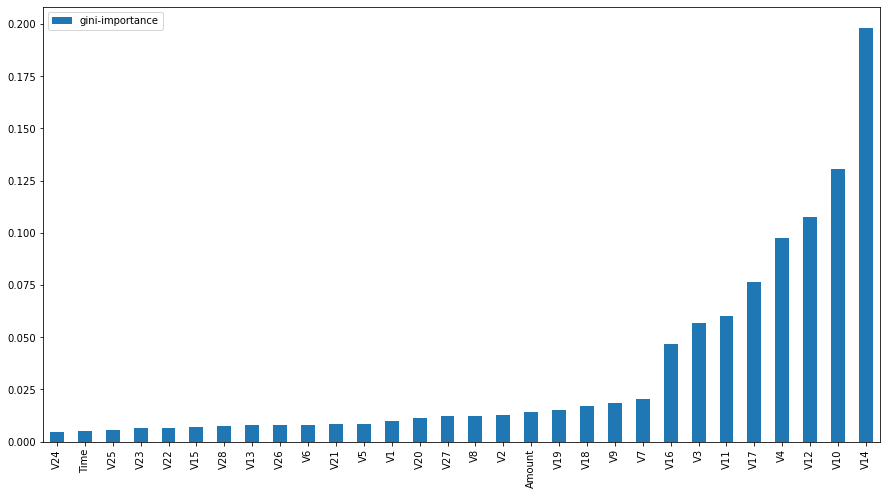

In [15]:
feats = {}
for feature, importance in zip(df.columns,model_gini.feature_importances_):
    feats[feature] = importance
important = pd.DataFrame.from_dict(feats,orient="index").rename(columns={0:"gini-importance"})
important.sort_values(by="gini-importance").plot(kind="bar"
                                                 ,rot=90,figsize=(15,8))

As we can see the most important featurea are:
> "V2","V7","V11","V3","V12","V4","V17","V10","V14"

So we'll make our model based on this features.

### Split and normalize data
Since our data is quite imbalanced, we can treat it as a **outlier problem**. So to normalization we'll use **RobustScaler** which is a normalization technique used to scale numerical data. It is more robust to outliers than other normalization techniques, such as **MinMaxScaler** or **StandardScaler**. And to avoid **data leakage** the scaler will be fit only the X_train dataset. 

In [7]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df = df[["V2","V7","V11","V3","V12","V4","V17","V10","V14","Class"]]
y = df.pop("Class")
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y
                                                          ,test_size=0.25, random_state=0, stratify=y)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=0,stratify=y_test)

scaler = RobustScaler()
scaler = scaler.fit(X_train)

X_train, X_test, X_dev = scaler.transform(X_train), scaler.transform(X_test), scaler.transform(X_dev)

In [8]:
X_train.shape, X_test.shape, X_dev.shape

((213605, 9), (35601, 9), (35601, 9))

# KNN Model

The basic idea behind the **KNN** model is to find the k closest neighbors to a new data point, based on a distance metric such as Euclidean distance or Manhattan distance. The distance metric measures the similarity between data points in the feature space. The k closest neighbors are determined based on their proximity to the new data point, with "k" being a hyperparameter that the user defines.

Our KNN model will follow the following steps:

1. Hyperparameter tuning, more expecifically neighbors.
2. Calculate the **AUC** for each weight function and select the one with the highest AUC as the best.
3. See how the model is performing on the test set using the cofusion matrix.

## Selecting hyperparameters based on the best AUC value

In [9]:
n_neighbors = [i for i in range(1,11)]

model_KNN = GridSearchCV(KNC(),param_grid = {'n_neighbors': n_neighbors},
                        scoring = {"precision":make_scorer(precision_score),"recall"
                                   :make_scorer(recall_score),"roc_auc":make_scorer(roc_auc_score)},
                        refit = "roc_auc",
                        cv=5,
                        n_jobs=-1)

In [10]:
model_KNN.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='roc_auc',
             scoring={'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

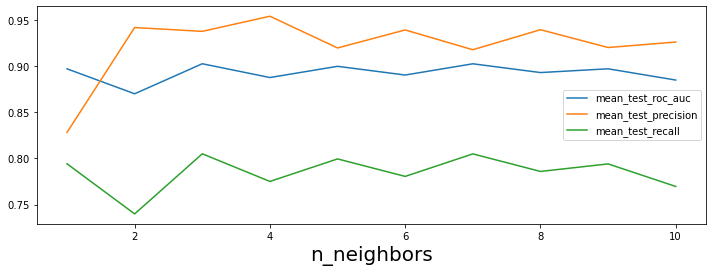

In [11]:
results = pd.DataFrame(model_KNN.cv_results_)

plt.figure(figsize=(12,4))
for score in ["mean_test_roc_auc","mean_test_precision","mean_test_recall"]:
    plt.plot([_ for _ in results["param_n_neighbors"]],results[score],label=score)
plt.legend()
plt.xlabel('n_neighbors', fontsize=20)
plt.show()

## KNN Cofusion matrix  

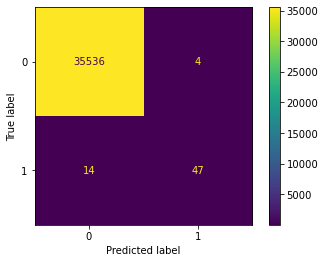

Recall: 0.7704918032786885
Precision: 0.9215686274509803
Area under the ROC curve: 0.885189627019198


In [12]:
y_pred = model_KNN.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Area under the ROC curve:", roc_auc_score(y_test, y_pred))

### As we can see from the confusion matrix, the KNN model has only 4 false positives, which indicates a high precision. However, the model was unable to detect 14 fraud cases, resulting in a recall rate of 77%.

# Random Forest Classifier Model

Random Forest Classifier is an ensemble machine learning algorithm that combines multiple decision trees to make predictions. It randomly selects a subset of features and data samples from the training dataset, constructs decision trees, and then combines their predictions through majority voting. This improves accuracy and reduces overfitting, making it a popular choice for classification tasks.

1. Hyperparameter tuning, more expecifically the number of decision trees (n_estimators).
2. Calculate AUC for each n_estimators and select the one with the highest AUC.
3. See how the model is performing on the test set using the cofusion matrix.

## Selecting hyperparameters based on the best AUC value

In [15]:
n_of_trees = [10*i for i in range(1,11)]

model_RFC = GridSearchCV(RandomForestClassifier(class_weight = class_weight_dic)
                         ,param_grid = {'n_estimators': n_of_trees},
                        scoring = {"precision":make_scorer(precision_score),"recall"
                                   :make_scorer(recall_score),"roc_auc":make_scorer(roc_auc_score)},
                        refit = "roc_auc",
                        cv=5,
                        n_jobs=-1)

In [16]:
model_RFC.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.5008652375006595,
                                                            1: 289.4380081300813}),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             refit='roc_auc',
             scoring={'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

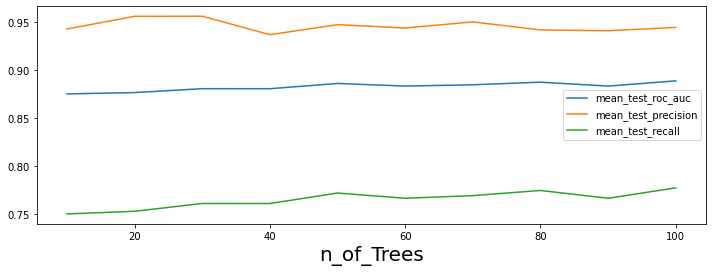

In [17]:
results = pd.DataFrame(model_RFC.cv_results_)

plt.figure(figsize=(12,4))
for score in ["mean_test_roc_auc","mean_test_precision","mean_test_recall"]:
    plt.plot([_["n_estimators"] for _ in results["params"]],results[score],label=score)
plt.legend()
plt.xlabel('n_of_Trees', fontsize=20)
plt.show()

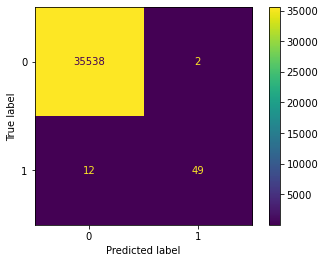

Recall: 0.8032786885245902
Precision: 0.9607843137254902
Area under the ROC curve: 0.9016112069522219


In [18]:
y_pred = model_RFC.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Area under the ROC curve:", roc_auc_score(y_test, y_pred))

### As we can see from the cofusion matrix, the RFC model have only two false positive which makes the precision better than the KNN model. It also have a better recall since is misclassified only 12 frauds.

# Deep Learning Model

For this section, I chose to use a **deep neural network** (DNN) as the model. A DNN is a type of artificial neural network that consists of multiple hidden layers between the input and output layers. These hidden layers allow the network to learn complex patterns and representations from data through **backpropagation**.

For our specific problem, we'll use the **Focal loss function**, which is a loss function created to deal with imbalanced data. I'll also use the **weight_class parameter** to balance the classes, which can help in mitigating the impact of class imbalance during training. Additionally, I will set the initial bias parameter as:

> b_0 = log(fraud_class/all_data)

This will help the loss function to **decrease faster** during training and potentially improve the model's ability to learn from imbalanced data.

In [44]:
metrics = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')  ]

In [26]:
b_0 = np.log(y_train.sum() / len(y_train))
output_bias = tf.keras.initializers.Constant([np.round(b_0)])

## Creating the layers
input_layer = Input(shape= X_train[-1].shape)

x = Dense(2**9, activation="relu")(input_layer)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

x = Dense(2**9, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

x = Dense(2**8, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)


x = Dense(2**8, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

x = Dense(2**6, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

x = Dense(2**6, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

output_layer= Dense(1, activation="sigmoid")(x)
##Defining the model by specifying the input and output layers
model = Model(inputs=input_layer, outputs=output_layer)
## defining the optimiser and loss function
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.5e-3),
      loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.1, gamma = 5),
      metrics=metrics)

In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               5120      
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0   

In [31]:
EPOCHS = 50 
BATCH_SIZE = 32

In [45]:
#history = model.fit(
#    X_train,
#    y_train,
#   batch_size=BATCH_SIZE,
#   epochs=50,
#   validation_data=(X_dev, y_dev),
#    class_weight = class_weight_dic,
#    verbose=1)

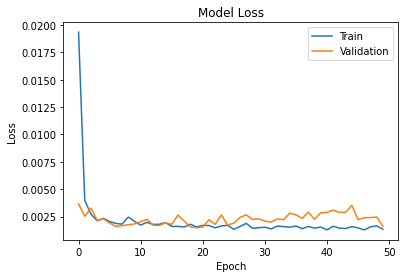

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

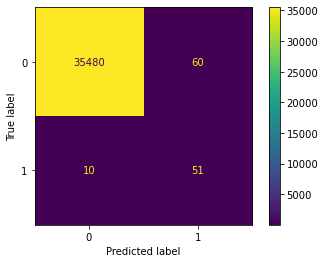

Recall: 0.8360655737704918
Precision: 0.4594594594594595
Area under the curve ROC: 0.9171886675830513


In [48]:
pred = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pred > 0.5)
plt.show()
print("Recall:", recall_score(y_test, pred>0.5))
print("Precision:", precision_score(y_test, pred>0.5))
print("Area under the curve ROC:", roc_auc_score(y_test, pred>0.5))

### As we can see from the cofusion matrix, the DNN model a better recall copared with the other models. But the precision is bad so ther must be improvimentss for it.

# Ensemble Voting model

Ensemble voting, also known as ensemble model or ensemble learning, is a machine learning technique where multiple models are combined to make predictions or decisions. The idea is that combining the outputs of several models can often result in better performance than using a single model alone.

In [39]:
def weight_mean(w,data):
    """Fuction that calculate the weighted average of the vote"""

    result = 0
    
    for i in range(3):
        result += data[i]*w[i]
    
    result = result/sum(w)
    
    return result

def Ensemble_Model(pred_1, pred_2, pred_3,w):
    """Hard voting model"""
    predictions = []
    for i in range(X_test.shape[0]):
        
        pred = [pred_1[i], pred_2[i], pred_3[i]]
        
        predictions.append(round(weight_mean(w,pred)))
    
    return predictions

In [40]:
pred_KNN = model_KNN.predict(X_test)
pred_RFC = model_RFC.predict(X_test)
pred_DNN = model.predict(X_test) > 0.5

In [42]:
result = Ensemble_Model(pred_KNN,pred_RFC,pred_DNN.reshape(-1,),[0.7,0.5,0.5])

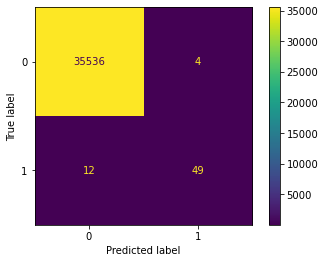

Recall: 0.8032786885245902
Precision: 0.9245283018867925
Área under the curve ROC: 0.9015830696421487


In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, result)
plt.show()
print("Recall:", recall_score(y_test, result))
print("Precision:", precision_score(y_test, result))
print("Área under the curve ROC:", roc_auc_score(y_test, result))

# Final Results

In [51]:
# Our models


,Model,Recall,Precision,AUC ROC
0,KNN,77.0%,92.1%,88.5%
1,Random Forest,80.3%,96.0%,90.1%
2,DNN,83.6%,45.9%,91.7%
3,Voting Classifier,80.3%,92.4%,90.1%
